In [1]:
import os
import pandas as pd
import numpy as np
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, transforms
import matplotlib.pyplot as plt

In [ ]:
from DataLoading import *

In [2]:
plt.rcdefaults()

# Use Odd spectrograms

In [3]:
def plot_spectrogram(spec, title, time, frequency, start_longest_mode=None, end_longest_mode=None):
    fig, ax = plt.subplots()
    ax.imshow(spec.T, extent=(time[0], time[-1], frequency[0], frequency[-1]), aspect='auto', cmap='jet',
              origin='lower')
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(frequency[0], frequency[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    fig.set_dpi(150)
    plt.title(title)

    # Plot vertical lines if start and end times are provided
    if start_longest_mode is not None and end_longest_mode is not None:
        ax.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        ax.axvline(x=end_longest_mode, color='darkblue', linestyle='--', label='End of Longest Mode')
        plt.legend(loc='upper left')

    plt.show()

In [73]:
class SpectrogramDataset(Dataset):
    def __init__(self, data_path, file_ext, window_size, transform=None, time_step=5.12e-4, overlap_factor = 0):
        """
        SpectrogramDataset constructor.

        Parameters:
        - data_path (str): Location of the data.
        - file_ext (str): File type of the data.
        - window_size (int): Number of time steps in each window.
        - transform (callable): Optional transform to be applied on a window.
        - time_step (float): Duration of each time step in ms.
        - overlap_factor (float): Fraction of overlap between consecutive windows (0 to 1).

        Attributes:
        - data_path (str): Location of the data.
        - file_ext (str): File type of the data.
        - window_size (int): Number of time steps in each window.
        - transform (callable): Optional transform to be applied on a window.
        - time_step (float): Duration of each time step in ms.
        - overlap_factor (float): Fraction of overlap between consecutive windows (0 to 1).
        - window_step (int): Step size for moving the window.

        Initializes the dataset by obtaining all shot numbers and precomputing all windows with unique IDs.
        """
        self.data_path = data_path
        self.file_ext = file_ext
        self.window_size = window_size
        self.transform = transform
        self.time_step = time_step
        self.overlap_factor = overlap_factor
        self.window_step = int(self.window_size * (1 - overlap_factor))  # Step size for moving the window

        # Obtain all shot numbers
        self.data_files = [int(os.path.basename(x.split(f".{file_ext}")[0]))
                           for x in glob.glob(os.path.join(data_path, f"*.{file_ext}"))]

        # Precompute and store all windows with unique IDs using a dictionnary
        self.windows = self.compute_all_windows()

    def __len__(self):
        """
        Returns the total number of windows in the dataset.
        """
        return len(self.windows)
    

    def __getitem__(self, idx):
        """
        Returns a single window based on the provided idx (unique identifier).

        Parameters:
        - idx (int): Unique identifier for the window.

        Returns:
        - window_dict (dict): A dictionary containing information about the window.
        """
        found_dict = next((my_dict for my_dict in self.windows if my_dict.get('unique_id') == idx), None)
        window_dict = {key: [value] for key, value in found_dict.items()}
        return window_dict
        #found_dict = next((my_dict for my_dict in self.windows if my_dict.get('unique_id') == idx), None)
        #return found_dict

    def load_shot(self, shotno):
        """
        Loads data for a specific experiment.

        Parameters:
        - shotno (int): Experiment (shot) number.

        Returns:
        - data_shot (pd.DataFrame): Data for the specified experiment.
        """
        file_path = os.path.join(self.data_path, f"{shotno}.{self.file_ext}")
        return pd.read_pickle(file_path)
    
    def compute_all_windows(self, overlap_factor=0):
        """
        Computes all windows with unique IDs for the dataset.

        Returns:
        - windows (list): A list of dictionaries, each containing information about a window.
        """
        windows = []
        unique_id = 0

        # For each experiment
        for shotno in self.data_files:
            data_shot = self.load_shot(shotno)

            spec_odd = torch.tensor(data_shot["x"]["spectrogram"]["OddN"], dtype=torch.float32).T
        
            frequency = data_shot["x"]["spectrogram"]["frequency"]
            time = data_shot["x"]["spectrogram"]["time"]

            # Compute sliding windows for OddN with overlap
            for i in range(0, len(time) - self.window_size + 1, self.window_step):
                start_idx = i
                end_idx = i + self.window_size

                slice_data = spec_odd[:, start_idx:end_idx]

                windows.append({
                    'unique_id': unique_id,
                    'window_odd': slice_data, # The odd spectrogram
                    'frequency': frequency,
                    'time': time[start_idx:end_idx],
                    'start_idx': start_idx,
                    'end_idx': end_idx,
                    'shotno': shotno
                })
                

                unique_id += 1

        # Print information about the generated windows
        total_windows = len(windows)
        print(f"The size of the odd spectrogram in the last element of windows: {windows[total_windows-1]['window_odd'].shape}.")
        print(f"Total number of windows = {total_windows}")
        print(f"Number of unique IDs = {unique_id}")

        return windows
    
# Custom collate function
def custom_collate(batch):
    return batch    
    
# Example usage
DATA_PATH = "data/dataset_pickle"
FILE_EXT = "pickle"
WINDOW_SIZE = 64 # Number of datapoints
OVERLAP_FACTOR = 0.8 # Overlap factor between 0 and 1 for each sliding window ("% overlap with the last window")

dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, window_size=WINDOW_SIZE, overlap_factor = OVERLAP_FACTOR)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn = custom_collate)

The size of the odd spectrogram in the last element of windows: torch.Size([2049, 64]).
Total number of windows = 20644
Number of unique IDs = 20644


In [79]:
# Iterate through the dataloader
for idx, batch in enumerate(dataloader):
    #print(f"Batch {idx + 1} - Number of Windows: {len(batch)}")
    print(batch[0]['window_odd'][0].shape) # First item of the batch --> Very weird indexing
    #break
        
    break  # Break after plotting the first window

torch.Size([2049, 64])


Batch 1 - Number of Windows: 7
torch.Size([2049, 64])


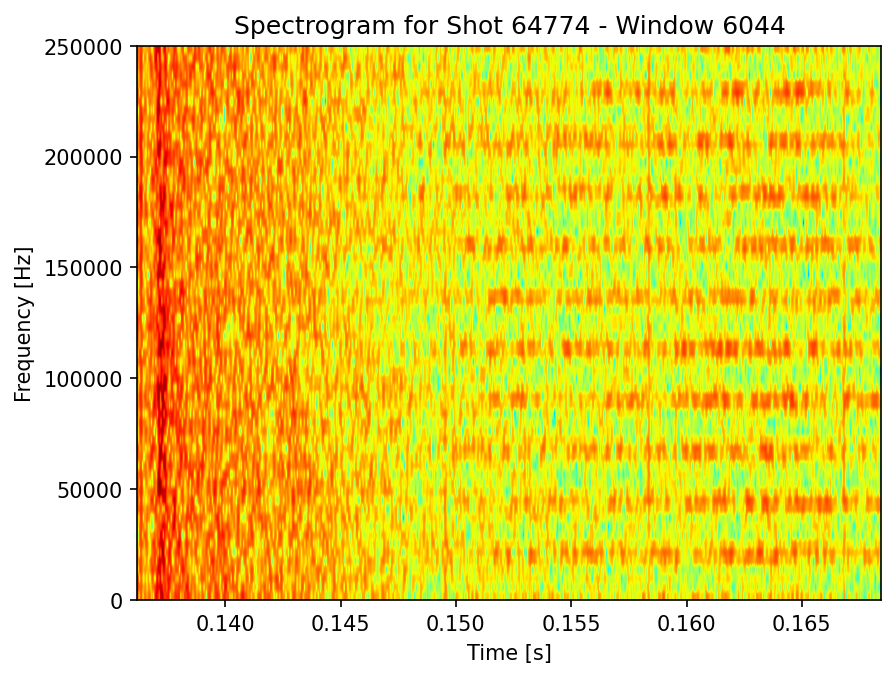

In [28]:
# Iterate through the DataLoader and plot the first element of the first batch
for idx, batch in enumerate(dataloader):
    print(f"Batch {idx + 1} - Number of Windows: {len(batch)}")
    print(batch['window_odd'][0].shape)

    plot_spectrogram(
    batch['window_odd'][1],
    f"Spectrogram for Shot {batch['shotno'][1]} - Window {batch['unique_id'][1]}",
    batch['time'][1],
    batch['frequency'][1]
    )
        
    break  # Break after plotting the first window